## Sales forecasting and elasticity pricing


I’m going to forecast daily sales of retail goods. The data were obtained from 3,049 individual products from 7 stores in California, Texas, and Wisconsin.


In [2]:
#Import packages
import pandas as pd
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pylab as plt

import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error 

## Exploratory Data Analysis (EDA)


## Read the dataset
Get to know more about this dataset

In [3]:
calendar = pd.read_csv('./m5-forecasting-accuracy/calendar.csv')
sales_train_validation = pd.read_csv('./m5-forecasting-accuracy/sales_train_validation.csv')
sell_prices = pd.read_csv('./m5-forecasting-accuracy/sell_prices.csv')

# calendar.sample()
# sales_train_validation.sample()
# sell_prices.sample()

In [80]:
sales_train_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


Here, these dataframe have large memory usage. Why? 2 reasons: 1. the dataset is large. 2. all the dtypes of number is int64. 

So we use a trick called downcast.

## Downcast
Downcast is a good way to shrink dataframe and save memory.

In [4]:
def downcast(df):
    fcols = df.select_dtypes('float').columns
    icols = df.select_dtypes('integer').columns

    df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
    df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')
    return df 

sales = downcast(sales_train_validation)
price = downcast(sell_prices)
calendar = downcast(calendar)

In [82]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int16(1288), int8(625), object(6)
memory usage: 94.5+ MB


After using the downcast method, the memory usage shrank from 446MB to 95MB.

### calendar

In [83]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int16 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int8  
 4   month         1969 non-null   int8  
 5   year          1969 non-null   int16 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int8  
 12  snap_TX       1969 non-null   int8  
 13  snap_WI       1969 non-null   int8  
dtypes: int16(2), int8(5), object(7)
memory usage: 125.1+ KB


* SNAP: Supplemental Nutrition Assistance Program. SNAP provides benefits to eligible low-income individuals and families via an Electronic Benefits Transfer card. This card can be used like a debit card to purchase eligible food in authorized retail food stores.

* There are many NULL in event_name_1, event_type_1, event_name_2 and event_type_2.

In [84]:
calendar['event_type_1'].value_counts()

Religious    55
National     52
Cultural     37
Sporting     18
Name: event_type_1, dtype: int64

In [86]:
calendar['event_name_1'].value_counts()

SuperBowl              6
Pesach End             6
Ramadan starts         6
ValentinesDay          6
NBAFinalsEnd           6
NBAFinalsStart         6
MemorialDay            6
Mother's day           6
Purim End              6
StPatricksDay          6
LentWeek2              6
LentStart              6
PresidentsDay          6
MartinLutherKingDay    5
OrthodoxChristmas      5
EidAlAdha              5
NewYear                5
Chanukah End           5
Christmas              5
Thanksgiving           5
VeteransDay            5
IndependenceDay        5
Halloween              5
ColumbusDay            5
LaborDay               5
Eid al-Fitr            5
Cinco De Mayo          5
OrthodoxEaster         5
Easter                 5
Father's day           4
Name: event_name_1, dtype: int64

In [88]:
#d_cols: all sales data columns
d_cols = [c for c in sales_train_validation.columns if 'd_' in c]
x_1 = sales_train_validation.loc[sales_train_validation['id'] == "FOODS_1_001_CA_1_validation"][d_cols].values[0][:100]
x_2 = sales_train_validation.loc[sales_train_validation['id'] == "FOODS_1_001_CA_1_validation"][d_cols].values[0][500:600]
x_3 = sales_train_validation.loc[sales_train_validation['id'] == "FOODS_1_001_CA_1_validation"][d_cols].values[0][1000:1100]

In [89]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines+markers', name="First period",
                         marker=dict(color="green")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines+markers', name="Second period",
                         marker=dict(color="orange")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines+markers', name="Third period",
                         marker=dict(color="dodgerblue")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales snippets")
fig.show()

* We can't tell much from figures, but there are many 0s.

## Data preprocessing

Every row in this dataset represent a time serious (multiple days' sales amount included). So that it is very innconvenient to consider price and holiday on a single day.

So I'll use pd.melt() function to make the "wide table" to "long table". Each row includes one day sales data and its price, holiday and promotion.

In [5]:
df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales').dropna()
#df

In [6]:
df = pd.merge(df, calendar, on='d', how='left')
#df

In [7]:
df = pd.merge(df, sell_prices, on=['store_id','item_id','wm_yr_wk'], how='left') 
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1913,1,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.98
58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,2.48
58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1913,0,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,3.98
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1913,3,2016-04-24,11613,...,4,2016,NaN,NaN,NaN,NaN,0,0,0,1.28


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58327370 entries, 0 to 58327369
Data columns (total 22 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   item_id       object 
 2   dept_id       object 
 3   cat_id        object 
 4   store_id      object 
 5   state_id      object 
 6   d             object 
 7   sales         int16  
 8   date          object 
 9   wm_yr_wk      int16  
 10  weekday       object 
 11  wday          int8   
 12  month         int8   
 13  year          int16  
 14  event_name_1  object 
 15  event_type_1  object 
 16  event_name_2  object 
 17  event_type_2  object 
 18  snap_CA       int8   
 19  snap_TX       int8   
 20  snap_WI       int8   
 21  sell_price    float32
dtypes: float32(1), int16(3), int8(5), object(13)
memory usage: 6.9+ GB


In [94]:
# df.to_parquet('./raw_sales_data.parquet')
# I cant save it. I dont know why.

In [95]:
df.isna().sum()

id                     0
item_id                0
dept_id                0
cat_id                 0
store_id               0
state_id               0
d                      0
sales                  0
date                   0
wm_yr_wk               0
weekday                0
wday                   0
month                  0
year                   0
event_name_1    53631910
event_type_1    53631910
event_name_2    58205410
event_type_2    58205410
snap_CA                0
snap_TX                0
snap_WI                0
sell_price      12299413
dtype: int64

In [96]:
#fill the nulls in 'sell_price' by the mean of this type of product. (They have the same id) 
df['sell_price']=df['sell_price'].fillna(df.groupby('id')['sell_price'].transform('mean'))

#fill the null event by 'no_event'
for i in ['event_name_1','event_type_1','event_name_2','event_type_2']:
    df[i].fillna('no_event',inplace=True)

## Bulid tree model

I wanted to try some traditional time serious method like Prophet. This algorithm does the forcasting by the trend, seasonality and external variables like holiday. When the dataset is large, and the features is complicated, it is really hard for Prophet to do the forcasting well.

And it has better interpretability than deep learning models, cause we don’t just need the output, we want to explain and explore something from the result. That's why I chose feature engineering and tree model.

# Feature engineering

## 1. Feature creation
1. Lags of historical sales: pd.shift(1)
2. Moving average (MA) of lags. Why not do MA on 'sales'? Prevent data leakage.
3. First difference: the series of changes from one period to the next.
4. Window max, min (or rolling max, min):

In [99]:
#.shift(lag)
horizon = 1 #if we predict sales of t+n, than we define n as horizon

In [100]:
#Lags:
#The sales of t should be highly relevant with the sales of t-1, t-7, t-30 and so on.
#I'll use pd.shift(lag)
lags=list(range(horizon, horizon+7))+ [14,30,60,90]
for lag in lags:
    df[f'sales_lag_{lag}'] = df.groupby(['id'],as_index=False)['sales'].shift(lag)

In [101]:
lag_columns = []
for lag in lags:
    lag_columns.append(f'sales_lag_{lag}')
for i in lag_columns:
    df[i]=df[i].fillna(0) 

In [ ]:
# Beside using lag-n, I use some statistics of lag.
# Rolling Window Statistics: the moving average calculation creates an updated average value for each row based on the window we specify.
# You take the last 5 days, sum them up and divide by 5.

# Expanding Window Statistics: 
# expanding windows have a fixed starting point, and incorporate new data as it becomes available

In [102]:
#windows = [2,3,5]
windows = [2,7]
for window in windows:
  df[f'rolling_mean_sales_window_{window}'] = df.groupby(['id'])['sales'].transform(lambda x: x.rolling(window=window).mean().shift(1))

In [103]:
df[f'sales_lag_diff_2_1'] = df[f'sales_lag_2'] - df[f'sales_lag_1']
df[f'sales_lag_diff_3_1'] = df[f'sales_lag_3'] - df[f'sales_lag_1']
df[f'sales_lag_diff_7_1'] = df[f'sales_lag_7'] - df[f'sales_lag_1']

In [104]:
df[f'rolling_min_sales_window_7'] = df.groupby(['id'])['sales'].transform(lambda x: x.rolling(window=7).min().shift(1))
#df[f'rolling_max_sales_window_7'] = df.groupby(['id'])['sales'].transform(lambda x: x.rolling(window=7).max().shift(1))

In [8]:
# Because this dataset is too large, I'm gonna using only a part of it.
# df = df[df['year'] >= 2014]

In [9]:
# convert d_1 to 1. This is the attributes that helps us split dataset.
df['d'] = df['d'].apply(lambda x: int(x.split('_')[1]))

/var/folders/pn/5mwzjk2d0pd453qd8x60cms80000gn/T/ipykernel_25684/4051596392.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['d'] = df['d'].apply(lambda x: int(x.split('_')[1]))


I made a mistake at dataset splitting at first. If I'll predict the t+1 sales by historic sales data, then the train set should be sales in past t days. But I splited data by product and by store, so that this task was like predict the sales of an product by sales of other product.

## Feature Selection
Why: 
1. To simplify the model and get better interpretability.
2. Save memory, reduce the amount of calculation.
3. Reduce the risks of overfitting. 


How: 
1. Remove target column (to prevent leakage) and invalid attributes.
2. Remove abnormal data.
3. Compute the correlation value of the attributes, and remove highly correlated ones (one of the two).

In [107]:
feature_cols = []
for col in df.columns:
    #'data': useless, we already have year, month and day. So this attribute is redundant.
    #'sales': remove to prevant leakage
    if col not in ['date', 'sales']:
        feature_cols.append(col)
#feature_cols
features = df[feature_cols]

In [108]:
# Now calculate the correlation value of numeric attributes. And remove the highly correlated ones.
num_features = features.select_dtypes(include=[np.number]).columns.tolist()

In [109]:
corr_matrix = features[num_features].corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

/var/folders/pn/5mwzjk2d0pd453qd8x60cms80000gn/T/ipykernel_24501/2466000512.py:3: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



,d,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price,sales_lag_1,...,sales_lag_14,sales_lag_30,sales_lag_60,sales_lag_90,rolling_mean_sales_window_2,rolling_mean_sales_window_7,sales_lag_diff_2_1,sales_lag_diff_3_1,sales_lag_diff_7_1,rolling_min_sales_window_7
d,NaN,0.976218,0.003080,0.131970,0.906870,0.021851,0.014059,0.013193,0.003777,0.014446,...,0.015036,0.013385,0.012040,0.009725,0.015433,0.016907,0.000164,0.000148,0.001038,0.003006
wm_yr_wk,NaN,NaN,0.012727,0.027849,0.928880,0.006521,0.002469,0.002023,0.003632,0.016476,...,0.016388,0.014397,0.010884,0.007603,0.017462,0.018646,0.000545,0.000874,0.000658,0.004843
wday,NaN,NaN,NaN,0.001504,0.002306,0.000840,0.007951,0.007951,0.000037,0.031233,...,0.033798,0.010786,0.028335,0.000326,0.022427,0.000103,0.028519,0.052730,0.003422,0.000348
month,NaN,NaN,NaN,NaN,0.296633,0.007650,0.007650,0.007650,0.001062,0.002677,...,0.001585,0.005918,0.010301,0.007823,0.002644,0.001867,0.000585,0.000891,0.004823,0.003205
year,NaN,NaN,NaN,NaN,NaN,0.010301,0.010301,0.010301,0.003188,0.015590,...,0.013368,0.010974,0.007761,0.006508,0.016537,0.017345,0.000483,0.000736,0.001889,0.004435
snap_CA,NaN,NaN,NaN,NaN,NaN,NaN,0.401770,0.401770,0.000113,0.011104,...,0.012524,0.012267,0.011909,0.011509,0.010393,0.002039,0.003910,0.007479,0.023457,0.000657
snap_TX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.551327,0.000060,0.007897,...,0.009538,0.010214,0.009725,0.010724,0.008780,0.005509,0.000793,0.000558,0.014623,0.003220
snap_WI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000051,0.007598,...,0.011479,0.012585,0.009691,0.007874,0.009809,0.006330,0.004269,0.004228,0.010696,0.004497
sell_price,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.140096,...,0.139795,0.139502,0.139153,0.139206,0.150275,0.162750,0.000037,0.000028,0.000143,0.088097
sales_lag_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.646750,0.618039,0.567564,0.561763,0.932144,0.851805,0.361993,0.390613,0.396864,0.747918


In [113]:
high_corr_cols = [col for col in num_features if any(upper[col] >= 0.92)]
high_corr_cols

['wm_yr_wk', 'year', 'rolling_mean_sales_window_2']

I believe it is unnecessary to create that many rolling statistics, because they are highly correlated. 

In [114]:
feature_cols = []
for col in num_features:
  if col not in high_corr_cols:
    feature_cols.append(col)
#feature_cols
num_features = df[feature_cols]
num_features

,d,wday,month,snap_CA,snap_TX,snap_WI,sell_price,sales_lag_1,sales_lag_2,sales_lag_3,...,sales_lag_7,sales_lag_14,sales_lag_30,sales_lag_60,sales_lag_90,rolling_mean_sales_window_7,sales_lag_diff_2_1,sales_lag_diff_3_1,sales_lag_diff_7_1,rolling_min_sales_window_7
32563320,1069,5,1,1,1,0,8.26,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.0,0.0,0.0
32563321,1069,5,1,1,1,0,3.97,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.000000,0.0,0.0,0.0,0.0
32563322,1069,5,1,1,1,0,2.97,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
32563323,1069,5,1,1,1,0,4.64,3.0,1.0,5.0,...,0.0,0.0,3.0,5.0,0.0,3.142857,-2.0,2.0,-3.0,0.0
32563324,1069,5,1,1,1,0,3.08,1.0,0.0,0.0,...,0.0,4.0,1.0,3.0,0.0,0.571429,-1.0,-1.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,1913,2,4,0,0,0,2.98,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,1.0,0.0,0.0
58327366,1913,2,4,0,0,0,2.48,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.142857,-1.0,-1.0,-1.0,0.0
58327367,1913,2,4,0,0,0,3.98,1.0,0.0,0.0,...,0.0,2.0,2.0,0.0,0.0,0.571429,-1.0,-1.0,-1.0,0.0
58327368,1913,2,4,0,0,0,1.28,1.0,3.0,0.0,...,1.0,2.0,1.0,0.0,1.0,0.857143,2.0,-1.0,0.0,0.0


In [115]:
feature_cols = []
for col in features.columns:
  if (col not in num_features) & (col not in high_corr_cols):
    feature_cols.append(col)
cate_features = df[feature_cols]
cate_features

,id,item_id,dept_id,cat_id,store_id,state_id,weekday,event_name_1,event_type_1,event_name_2,event_type_2
32563320,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,Wednesday,NewYear,National,no_event,no_event
32563321,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,Wednesday,NewYear,National,no_event,no_event
32563322,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,Wednesday,NewYear,National,no_event,no_event
32563323,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,Wednesday,NewYear,National,no_event,no_event
32563324,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,Wednesday,NewYear,National,no_event,no_event
...,...,...,...,...,...,...,...,...,...,...,...
58327365,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,Sunday,no_event,no_event,no_event,no_event
58327366,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,Sunday,no_event,no_event,no_event,no_event
58327367,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,Sunday,no_event,no_event,no_event,no_event
58327368,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,Sunday,no_event,no_event,no_event,no_event


In [116]:
labelencoder=LabelEncoder() 
for col in cate_features.columns:
    cate_features[col] = labelencoder.fit_transform(cate_features[col])

In [117]:
features = pd.concat([num_features,cate_features], axis=1)

#parquet is smaller and faster than csv
features.to_parquet('all_feature.parquet')

In [2]:
features = pd.read_parquet('all_feature.parquet')
features

,d,wday,month,snap_CA,snap_TX,snap_WI,sell_price,sales_lag_1,sales_lag_2,sales_lag_3,...,item_id,dept_id,cat_id,store_id,state_id,weekday,event_name_1,event_type_1,event_name_2,event_type_2
32563320,1069,5,1,1,1,0,8.26,0.0,0.0,0.0,...,1437,3,1,0,0,6,18,1,2,2
32563321,1069,5,1,1,1,0,3.97,0.0,0.0,0.0,...,1438,3,1,0,0,6,18,1,2,2
32563322,1069,5,1,1,1,0,2.97,0.0,0.0,0.0,...,1439,3,1,0,0,6,18,1,2,2
32563323,1069,5,1,1,1,0,4.64,3.0,1.0,5.0,...,1440,3,1,0,0,6,18,1,2,2
32563324,1069,5,1,1,1,0,3.08,1.0,0.0,0.0,...,1441,3,1,0,0,6,18,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,1913,2,4,0,0,0,2.98,0.0,0.0,1.0,...,1432,2,0,9,2,3,30,4,2,2
58327366,1913,2,4,0,0,0,2.48,1.0,0.0,0.0,...,1433,2,0,9,2,3,30,4,2,2
58327367,1913,2,4,0,0,0,3.98,1.0,0.0,0.0,...,1434,2,0,9,2,3,30,4,2,2
58327368,1913,2,4,0,0,0,1.28,1.0,3.0,0.0,...,1435,2,0,9,2,3,30,4,2,2


In [23]:
# train : valid : test = 6:3:1
train = features[features['d']<1575]
valid = features[(features['d']>=1575) & (features['d']<1828)]
test = features[features['d']>=1828]

train_y = df[df['d']<1575]['sales']
valid_y = df[(df['d']>=1575) & (df['d']<1828)]['sales']
test_y = df[df['d']>=1828]['sales']

train_y = pd.DataFrame(train_y)
valid_y = pd.DataFrame(valid_y)
test_y = pd.DataFrame(test_y)

train_y.to_csv('train_y.csv')
valid_y.to_csv('valid_y.csv')
test_y.to_csv('test_y.csv')

In [3]:
train_y = pd.read_csv('train_y.csv')
valid_y = pd.read_csv('valid_y.csv')
test_y = pd.read_csv('test_y.csv')

train = pd.read_parquet('train.parquet')
valid = pd.read_parquet('valid.parquet')
test = pd.read_parquet('test.parquet')

## Building model

In [4]:
# An evaluation measure that are wildly used in real-world problem: SMAPE(symmetric_mean_absolute_percentage_error)
# I learned this at a bootcamp.
def SMAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(np.abs(y_true - y_pred) * 2) / np.sum(np.abs(y_true) + np.abs(y_pred))

In [5]:
# I changed the eval metric in lgb.
# The operation is from lgb official document and course materials of the bootcamp.
def lgbm_smape(y_true, y_pred):
    smape_val = SMAPE(y_true, y_pred)
    return 'SMAPE', smape_val, False
    #'SMAPE': name
    #smape_val: value
    #False: the smaller the better

In [6]:
cate_features = ['id',
 'item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'weekday',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2']

In [29]:
model_params = {
    'boosting_type':'gbdt',
    'objective': 'rmse',
    'num_leaves': 127,
    'learning_rate': 0.15,
    'n_estimators': 200,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbose': 1,
    'max_bin': 100,
    'max_depth':9,
    'n_jobs': 16,
    'seed': 4216,
}
m = lgb.LGBMRegressor(**model_params)
target = "demand"
m.fit(X=train, y=train_y['sales'],
      eval_set = [(valid, valid_y['sales'])],
      eval_metric=lgbm_smape,
      categorical_feature=cate_features,
      verbose= 10,
)

/Users/zhenyuanzhang/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/zhenyuanzhang/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat_id', 'dept_id', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2', 'id', 'item_id', 'state_id', 'store_id', 'weekday']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.999268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29873
[LightGBM] [Info] Number of data points in the train set: 15427940, number of used features: 34


/Users/zhenyuanzhang/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/zhenyuanzhang/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Start training from score 1.180387
[10]	valid_0's rmse: 2.14061	valid_0's SMAPE: 0.801639
[20]	valid_0's rmse: 2.02983	valid_0's SMAPE: 0.746514
[30]	valid_0's rmse: 2.01444	valid_0's SMAPE: 0.735618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's rmse: 2.00873	valid_0's SMAPE: 0.73175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's rmse: 2.00687	valid_0's SMAPE: 0.730327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's rmse: 2.00541	valid_0's SMAPE: 0.729571
[L

LGBMRegressor(bagging_fraction=0.8, feature_fraction=0.8, learning_rate=0.15,
              max_bin=100, max_depth=9, n_estimators=200, n_jobs=16,
              num_leaves=127, objective='rmse', seed=4216, verbose=1)

In [30]:
pred_lgb = m.predict(test)

In [31]:
mean_squared_error(test_y['sales'], pred_lgb, squared=False)

1.9976243400764555

In [32]:
SMAPE(test_y['sales'], pred_lgb)

0.7114617292861968

In [34]:
pred_lgb = pd.DataFrame(pred_lgb.round())
pred_lgb.to_csv('pred_lgb.csv')

<Figure size 432x288 with 0 Axes>

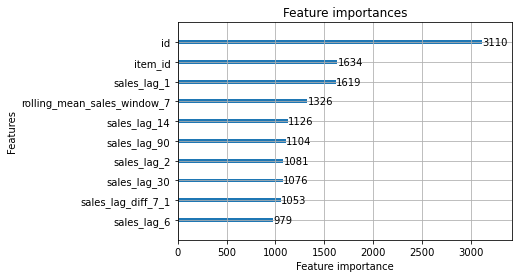

In [33]:
plt.figure()
lgb.plot_importance(m, max_num_features=10)
plt.title("Feature importances")
plt.show()

# Other tree models

1. Decision tree

2. Random forest

In [19]:
#Desicion Tree
#Actrually, there is a deficiency: I didn't(can't) change evaluation measure of decision tree and random forest to SMAPE. So I failed to control variates in this experiment. 

from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion = "entropy") 
clf = clf.fit(train,train_y['sales'])

pred_dt = clf.predict(test)

print(mean_squared_error(test_y['sales'], pred_dt, squared=False))
print(SMAPE(test_y['sales'], pred_dt))

2.9686624890806654
0.9453053433867051


In [20]:
#Random forest
from sklearn.ensemble import RandomForestClassifier
 
# I tried to use larger n_estimators. But it's too slow, or runs forever.
rf = RandomForestClassifier(n_estimators=20,max_depth=8,criterion='entropy')
rf = rf.fit(train,train_y['sales'])

pred_rf = rf.predict(test)

print(mean_squared_error(test_y['sales'], pred_rf, squared=False))
print(SMAPE(test_y['sales'], pred_rf))

2.6250369424843787
1.179365775665541


## Reference
1.downcast: 
1. https://pypi.org/project/pandas-downcast/

2. https://stackoverflow.com/questions/65842209/how-to-downcast-numeric-columns-in-pandas

2.LGB: https://lightgbm.readthedocs.io/en/v3.3.2/

3.visualize feature importance：https://blog.csdn.net/QQ96WWE/article/details/115367756

4.EDA：https://www.kaggle.com/code/mubashir1/one-tutorial-to-understand-all-m5-forecasting

5.fill nan data：https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group

6.feature engineering：
1. https://www.kaggle.com/code/sergioli212/m5-all-feature-engineering-ready-to-use/notebook

2. https://blog.csdn.net/weixin_46713695/article/details/126333544

7.about drop highly correlated features: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas